In [1]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### prepare the TFD/E results

In [2]:
# load the results
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/P3856'
RESULTS_DB_NAME = '{}/summarised-results/results.sqlite'.format(EXPERIMENT_DIR)
db_conn = sqlite3.connect(RESULTS_DB_NAME)
results_df = pd.read_sql_query("select * from sequences", db_conn)
db_conn.close()

In [3]:
len(results_df)

23295

In [4]:
# convert the identifications from JSON to Python objects
results_df['identifications_d'] = results_df.apply(lambda row: json.loads(row.identifications), axis=1)

In [5]:
# separate some key metrics into separate columns
results_df['id_perc_q_value'] = results_df.apply(lambda row: row.identifications_d['perc_q_value'], axis=1)
results_df['id_count_all_runs'] = results_df.apply(lambda row: len(row.identifications_d['run_names']), axis=1)
results_df['id_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s for s in row.identifications_d['run_names']), axis=1)

In [6]:
# remove the results that couldn't be extracted or were not classified as a target
results_df = results_df[results_df.extractions.notnull()].copy()

In [7]:
# convert from JSON to Python objects
results_df['extractions_l'] = results_df.apply(lambda row: json.loads(row.extractions), axis=1)

In [8]:
# separate some key metrics into separate columns
results_df['ext_count_all_runs'] = results_df.apply(lambda row: len(row.extractions_l), axis=1)
results_df['ext_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s['run_name'] for s in row.extractions_l), axis=1)

In [9]:
results_df.sample(n=3)

,sequence,charge,human,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_count_human_only_runs,extractions_l,ext_count_all_runs,ext_count_human_only_runs
12823,LTGPGLSEGPEPSISVM[15.9949]VTGGPWPTR,3,1,"{""perc_q_value"": 0.004730448, ""run_names"": [""P...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 0.004730448, 'run_names': ['P...",0.004730,1,0,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",28,9
4695,ELQENQDEIENMMNAIFK,3,1,"{""perc_q_value"": 1.9703545999999998e-05, ""run_...","[{""run_name"": ""P3856_YHE114_6_Slot1-1_1_5120"",...","{'perc_q_value': 1.9703545999999998e-05, 'run_...",0.000020,2,0,"[{'run_name': 'P3856_YHE114_6_Slot1-1_1_5120',...",7,0
10097,ISSEAWPPVGTPPSSESEPVR,2,1,"{""perc_q_value"": 6.2318886e-06, ""run_names"": [...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 6.2318886e-06, 'run_names': [...",0.000006,3,3,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",30,10


In [129]:
# count the number of unique peptide identifications in each run
counts_d = {}
for row in results_df.itertuples():
    for run_name in row.identifications_d['run_names']:
        if run_name not in counts_d:
            counts_d[run_name] = 0
        counts_d[run_name] += 1

In [143]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, counts_d[k]))
sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])

#### prepare the MaxQuant results

In [145]:
mq_results_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/experiments/P3856/evidence-P3856.txt', sep='\\t', engine='python')

In [146]:
# remove decoys, which are indicated by a '+' in the Reverse column
mq_results_df = mq_results_df[pd.isna(mq_results_df.Reverse)]
# remove identifications with no intensity
mq_results_df = mq_results_df[(mq_results_df.Intensity > 0)]
# remove potential contaminants
mq_results_df = mq_results_df[pd.isna(mq_results_df['Potential contaminant'])]
# remove identifications with mass error more than +/- 5 ppm
mq_results_df = mq_results_df[np.abs(mq_results_df['Mass error [ppm]']) <= 5.0]

In [147]:
mq_results_df.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/z difference', 'Match K0 difference', 'Match q-value',
       'M

In [148]:
# definition of uniqueness in MaxQuant output with MBR on
unique_peptide_key = ['Sequence','Modifications','Charge']

In [149]:
# count the number of unique peptide identifications in each run
mq_counts_d = {}
for group_name,group_df in mq_results_df.groupby(unique_peptide_key, as_index=False):
    df = group_df[(group_df.Type == 'TIMS-MULTI-MSMS')]
    for run_name in df['Raw file'].unique():
        if run_name not in mq_counts_d:
            mq_counts_d[run_name] = 0
        mq_counts_d[run_name] += 1

In [150]:
mq_sorted_counts_l = []
for k in sorted(mq_counts_d.keys()):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:3])
    mq_sorted_counts_l.append((short_run_name, mq_counts_d[k]))
mq_sorted_counts_df = pd.DataFrame(mq_sorted_counts_l, columns=['run_name','count'])

#### plot the unique peptide level

In [151]:
merged_df = pd.merge(sorted_counts_df, mq_sorted_counts_df, how='inner', left_on=['run_name'], right_on=['run_name'], suffixes=['_tfd_e','_mq'])
merged_df.index = merged_df.run_name

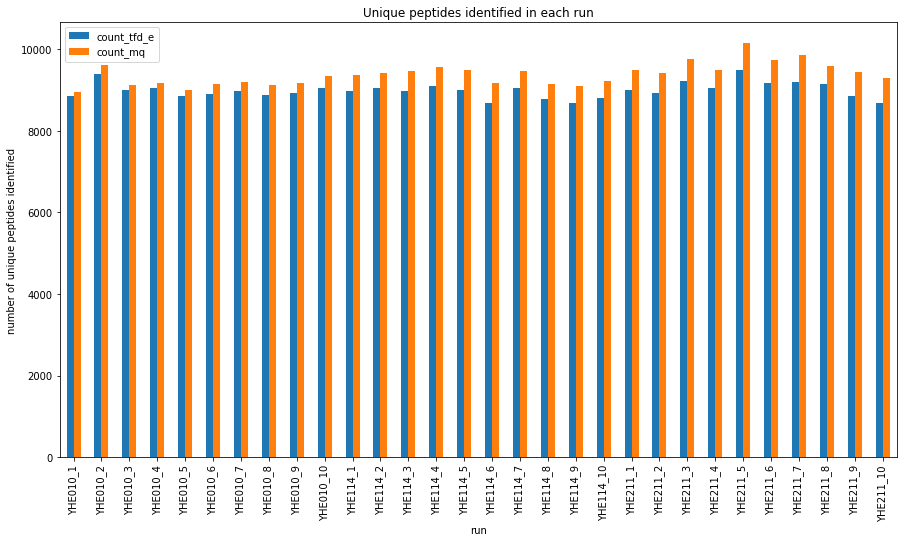

In [152]:
merged_df.plot(kind='bar', figsize=(15,8))
_ = plt.title("Unique peptides identified in each run")
_ = plt.xlabel("run")
_ = plt.ylabel("number of unique peptides identified")

In [153]:
merged_df[merged_df.run_name == 'YHE211_1']

,run_name,count_tfd_e,count_mq
run_name,,,
YHE211_1,YHE211_1,8995,9489


## missing-ness heatmaps

#### prepare the TFD/E data

In [154]:
# gather the lower intensity decile
results_df.columns

Index(['sequence', 'charge', 'human', 'identifications', 'extractions',
       'identifications_d', 'id_perc_q_value', 'id_count_all_runs',
       'id_count_human_only_runs', 'extractions_l', 'ext_count_all_runs',
       'ext_count_human_only_runs'],
      dtype='object')

In [155]:
results_df.iloc[0].extractions_l

[{'run_name': 'P3856_YHE010_9_Slot1-1_1_5101',
  'prob_target': 0.5535360344747312,
  'intensity': 181,
  'inferred': 0}]

In [156]:
sequences_l = []
for row in results_df.itertuples():
    for group_name in ['YHE114','YHE211','YHE010']:
        if sum(group_name in s for s in row.identifications_d['run_names']) > 0:
            for extraction in row.extractions_l:
                if group_name in extraction['run_name']:
                    short_run_name = '_'.join(extraction['run_name'].split('_Slot')[0].split('_')[1:3])
                    sequences_l.append((row.sequence, row.charge, row.human, row.id_perc_q_value, short_run_name, group_name, extraction['intensity']))
sequences_df = pd.DataFrame(sequences_l, columns=['sequence', 'charge', 'human', 'id_perc_q_value', 'short_run_name', 'group','intensity'])


In [157]:
sequences_df.sample(n=10)

,sequence,charge,human,id_perc_q_value,short_run_name,group,intensity
243825,LYTVCDVAMNIIMSK,2,1,0.000006,YHE010_7,YHE010,841
11792,AHDGGIYAISWSPDSTHLLSASGDK,3,1,0.000004,YHE211_6,YHE211,909
283850,QFLFRPWDVTK,2,1,0.000006,YHE211_10,YHE211,1908
297120,Q[-17.0265]EAGISEGQGTAGEEEEKK,2,1,0.000017,YHE114_9,YHE114,764
57488,DNTQLLINQLWQLPTER,3,1,0.000006,YHE114_10,YHE114,430
406520,WGDAGAEYVVESTGVFTTMEK,3,1,0.000004,YHE114_4,YHE114,309
151808,HGGICDCQTSR,2,1,0.000004,YHE211_8,YHE211,3004
130731,GIDELMISLDGTSNK,2,0,0.001229,YHE114_7,YHE114,1473
346747,TDYNASVSVPDSSGPER,2,1,0.000004,YHE211_2,YHE211,4338
68657,EALEHLCTYEK,2,1,0.000006,YHE211_4,YHE211,3982


In [158]:
# find the mean intensity for each peptide in each group
intensities_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge','group'], as_index=False):
    mean_intensity = group_df.intensity.mean()
    intensities_l.append((group_name[0], group_name[1], group_name[2], mean_intensity))
intensities_df = pd.DataFrame(intensities_l, columns=['sequence', 'charge', 'group', 'group_mean_intensity'])

In [159]:
# sort each group by descending intensity
intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [160]:
intensities_df.tail()

,sequence,charge,group,group_mean_intensity
21506,LEQASGASSSQEAGSSQAAK,2,YHE211,92.000000
13749,GILVLIPGNPM[15.9949]LNIIVSTFIFVCVAHEISQITNDLAQ...,4,YHE211,91.000000
2442,APSWPVVPPEEHSSFAPDSSAFPPATPR,4,YHE211,84.833333
18137,IGYNPDTVAFVPISGWNGDNMLEPSANMPWFK,3,YHE010,83.800000
28794,NSRPEANEALER,2,YHE010,78.833333


In [161]:
# make a separate DF for each group
yhe010_df = intensities_df[(intensities_df.group == 'YHE010')].copy()
yhe114_df = intensities_df[(intensities_df.group == 'YHE114')].copy()
yhe211_df = intensities_df[(intensities_df.group == 'YHE211')].copy()

In [162]:
# find the lowest-intensity peptides in each group
lower_proportion = 0.1
yhe010_lowest_df = yhe010_df.tail(int(lower_proportion * len(yhe010_df)))
yhe114_lowest_df = yhe114_df.tail(int(lower_proportion * len(yhe114_df)))
yhe211_lowest_df = yhe211_df.tail(int(lower_proportion * len(yhe211_df)))

## TFD/E heatmaps

#### plot YHE010

In [168]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE010'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [178]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe010_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

In [179]:
occurences_df.head()

,YHE010_1,YHE010_2,YHE010_3,YHE010_4,YHE010_5,YHE010_6,YHE010_7,YHE010_8,YHE010_9,YHE010_10
"VQSSYLHSLLEMGELLK,3",0.000000,8.693487,8.854868,0.000000,0.000000,0.000000,8.400879,9.047124,0.000000,8.758223
"SYGLSVVPEPAGCTPELPGEIIK,2",8.252665,8.816984,8.611025,8.903882,9.052568,8.622052,8.836050,8.727920,8.546894,9.098032
"DSWLDNIDWVK,2",7.651052,8.845490,7.930737,8.344296,9.177420,8.573647,8.778077,10.048487,8.383704,8.366322
"ELEFLSMANVELSSLAR,2",8.144658,8.134426,7.459432,10.005625,7.965784,8.144658,9.296916,7.727920,9.426265,9.025140
"GGSGYVNQLSAGYESVDSPTGSENSLTHQSNDTDSSHDPQEEK,4",8.768184,8.774787,8.870365,9.057992,8.632995,8.658211,8.294621,8.968667,8.962896,8.483816


Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE010')

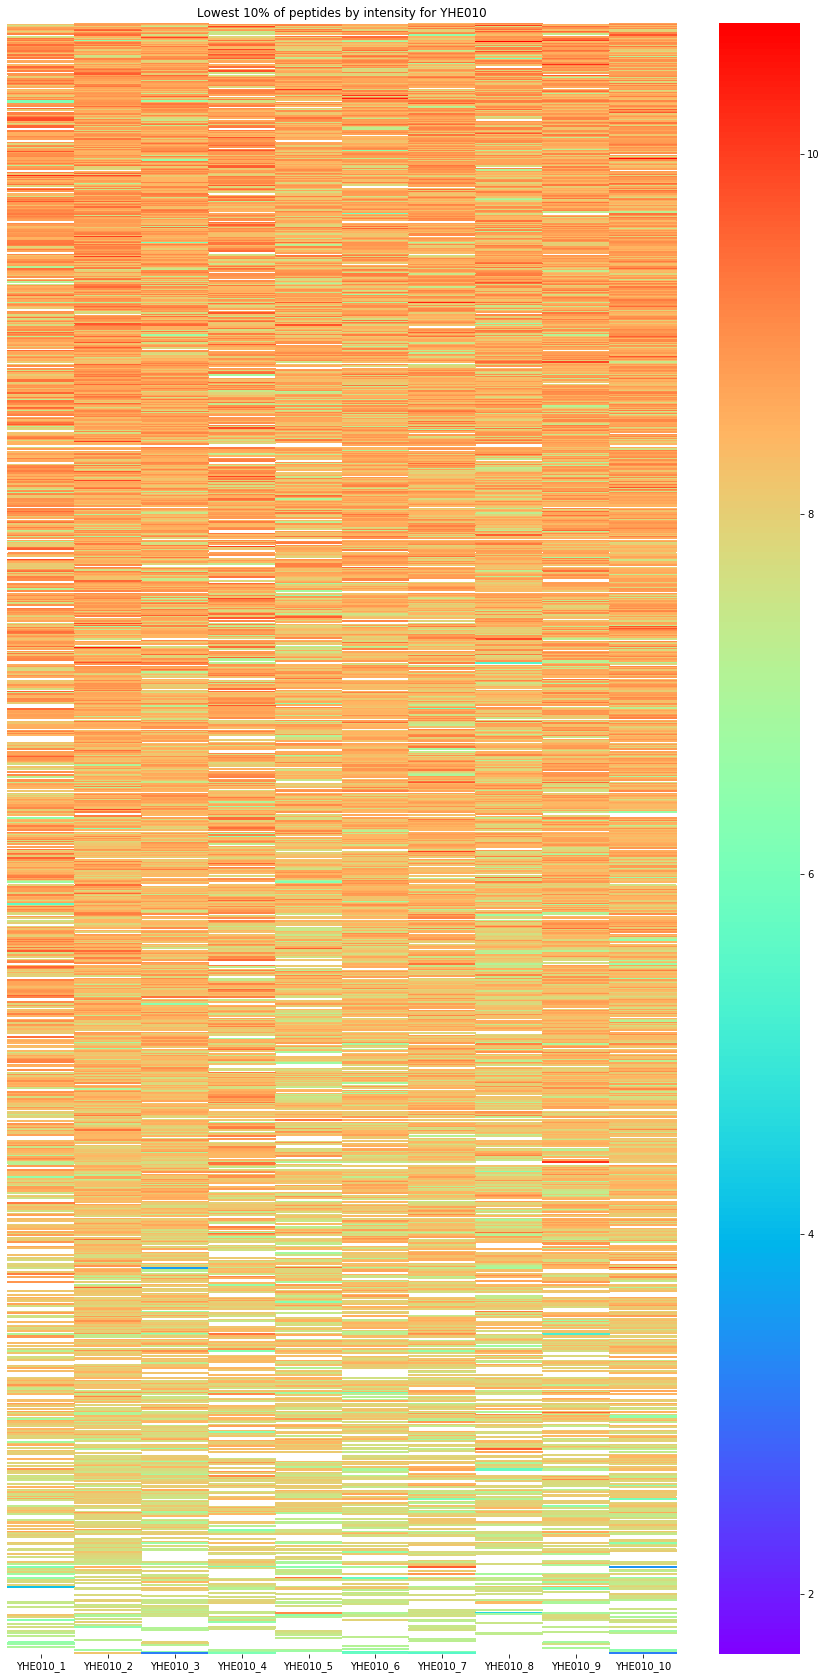

In [180]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE010'.format(int(lower_proportion*100)))

#### plot YHE114

In [184]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE114'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [185]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe114_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE114')

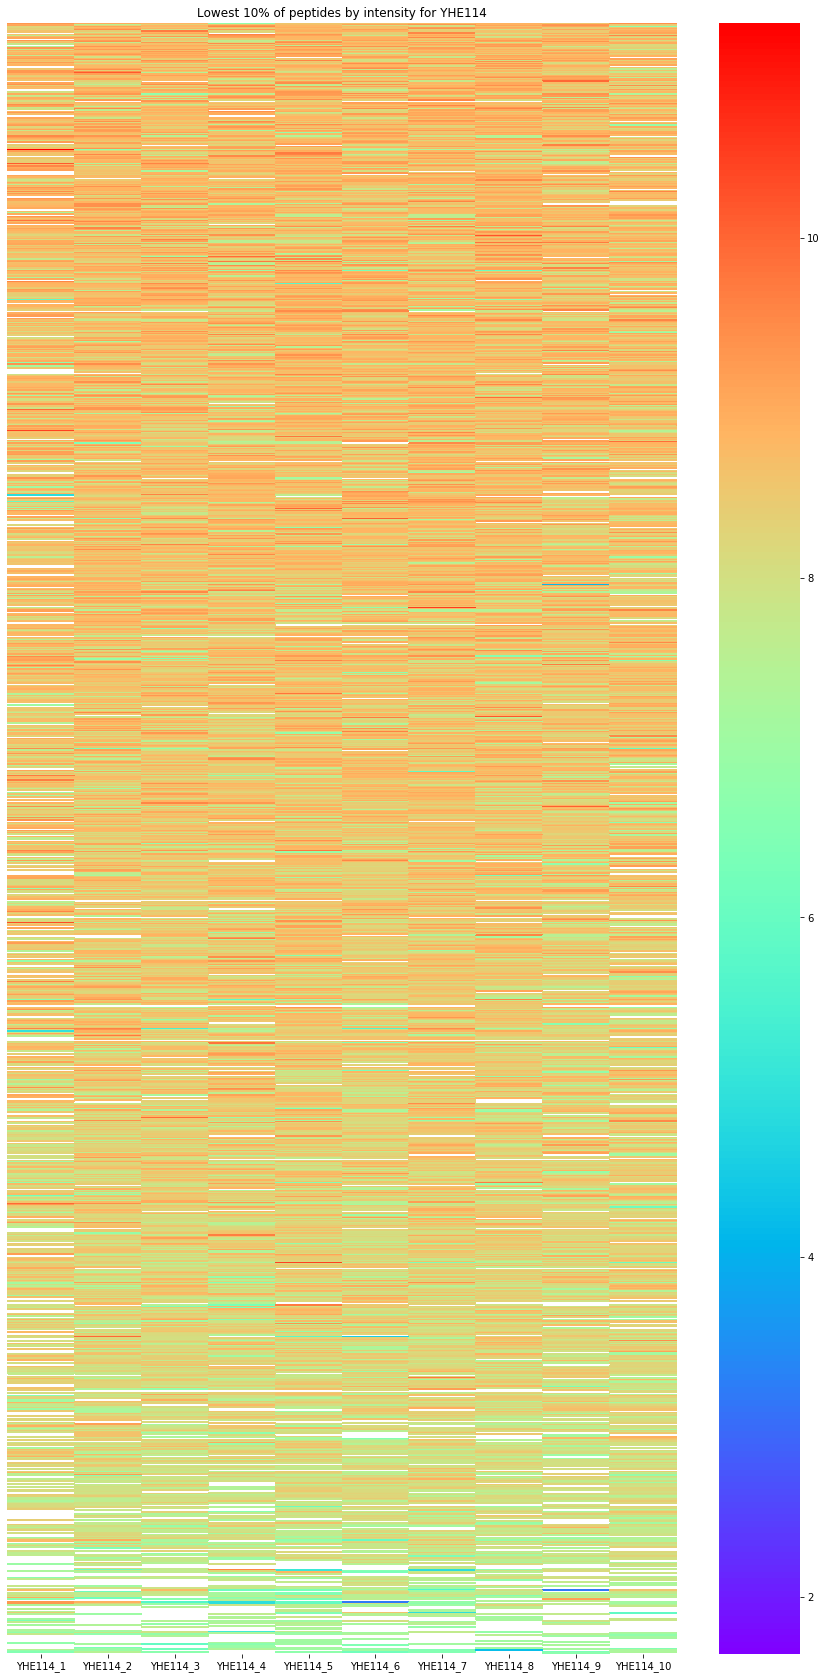

In [186]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE114'.format(int(lower_proportion*100)))

#### plot YHE211

In [187]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [189]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE211')

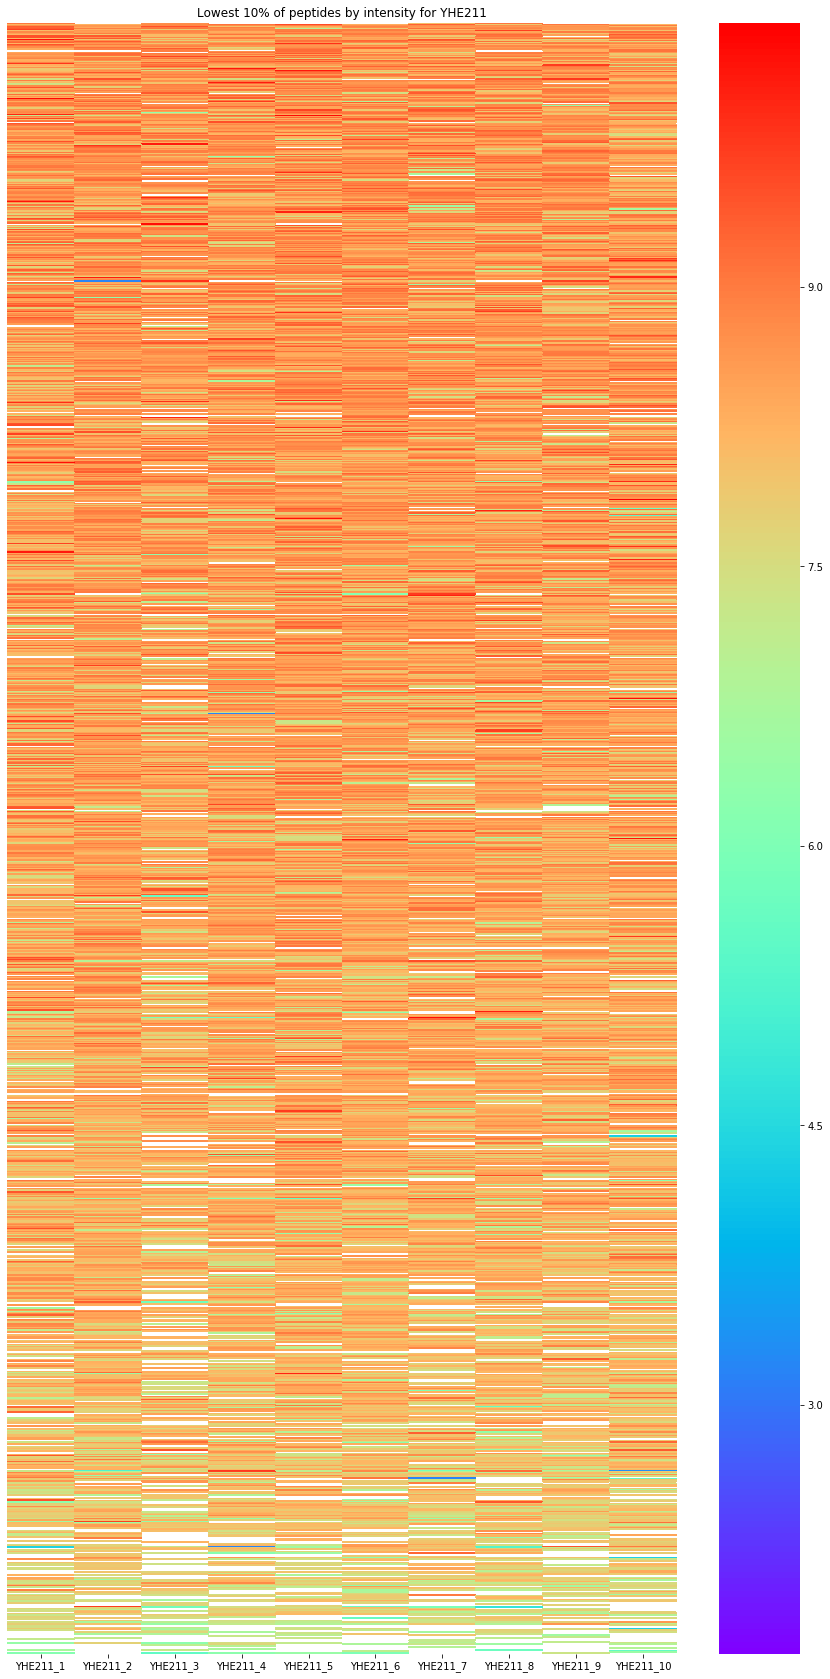

In [190]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE211'.format(int(lower_proportion*100)))

## MaxQuant heatmaps

In [192]:
mq_results_df.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/z difference', 'Match K0 difference', 'Match q-value',
       'M

In [195]:
# get one reading for each unique peptide in each run, and count how many identifications and extractions (i.e. 
# matches) across each group. Note that a sequence can be counted as an identification and a match in the same file 
# (i.e. it's given a different score).
mq_sequences_l = []
unique_peptide_key_file = unique_peptide_key + ['Raw file']
for group_name,group_df in mq_results_df.groupby(unique_peptide_key_file, as_index=False):
    identified_in_file = (len(group_df[group_df.Type == 'TIMS-MULTI-MSMS']) > 0)
    short_run_name = '_'.join(group_name[3].split('_Slot')[0].split('_')[1:3])
    grp_name = short_run_name.split('_')[0]
    sorted_df = group_df.sort_values(by=['Intensity'], ascending=False, inplace=False)
    if identified_in_file:
        score = sorted_df.iloc[0]['Score']
    else:
        score = sorted_df.iloc[0]['Match score']
    intensity = sorted_df.iloc[0].Intensity
    mq_sequences_l.append((group_name[0], group_name[1], group_name[2], short_run_name, grp_name, identified_in_file, score, intensity))
mq_sequences_df = pd.DataFrame(mq_sequences_l, columns=['sequence','modifications','charge','short_run_name','group','identified_in_file','score','intensity'])


In [196]:
mq_sequences_df.sample(n=5)

,sequence,modifications,charge,short_run_name,group,identified_in_file,score,intensity
31776,AVEALDHCVEEVAK,Unmodified,2,YHE114_2,YHE114,True,57.003,19025.0
94054,EVQGSTLAQLTSK,Unmodified,2,YHE114_6,YHE114,False,103.220,10521.0
209446,LLDLVQQSCNYK,Unmodified,2,YHE010_3,YHE010,True,132.390,121800.0
68008,EAPNPIHLTVDTSLQNGR,Unmodified,2,YHE211_3,YHE211,True,66.509,79197.0
219322,LPFLYSSQGPQAVR,Unmodified,2,YHE211_4,YHE211,True,61.577,32717.0


In [197]:
# find the mean intensity for each peptide in each group
mq_intensities_l = []
for group_name,group_df in mq_sequences_df.groupby(['sequence','modifications','charge','group'], as_index=False):
    mean_intensity = group_df.intensity.mean()
    mq_intensities_l.append((group_name[0], group_name[1], group_name[2], group_name[3], mean_intensity))
mq_intensities_df = pd.DataFrame(mq_intensities_l, columns=['sequence', 'modifications', 'charge', 'group', 'group_mean_intensity'])

In [198]:
# sort each group by descending intensity
mq_intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [199]:
mq_intensities_df.tail()

,sequence,modifications,charge,group,group_mean_intensity
46385,VDNAYWLWTFQGR,Unmodified,2,YHE114,873.45
34372,NYLPLLEPVKPEPK,Unmodified,2,YHE211,869.28
8699,EATWTMSNITAGR,Unmodified,2,YHE010,756.94
3300,AQLAQDGVQLCALDDLDSK,Unmodified,2,YHE114,728.88
27256,LMAPYTPFLTELMYQNLK,Unmodified,2,YHE010,719.49


In [200]:
# make a separate DF for each group
yhe010_df = mq_intensities_df[(mq_intensities_df.group == 'YHE010')].copy()
yhe114_df = mq_intensities_df[(mq_intensities_df.group == 'YHE114')].copy()
yhe211_df = mq_intensities_df[(mq_intensities_df.group == 'YHE211')].copy()

In [201]:
# find the lowest-intensity peptides in each group
lower_proportion = 0.1
yhe010_lowest_df = yhe010_df.tail(int(lower_proportion * len(yhe010_df)))
yhe114_lowest_df = yhe114_df.tail(int(lower_proportion * len(yhe114_df)))
yhe211_lowest_df = yhe211_df.tail(int(lower_proportion * len(yhe211_df)))

#### plot YHE010

In [202]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE010'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [203]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe010_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE010 by MaxQuant (N=1613)')

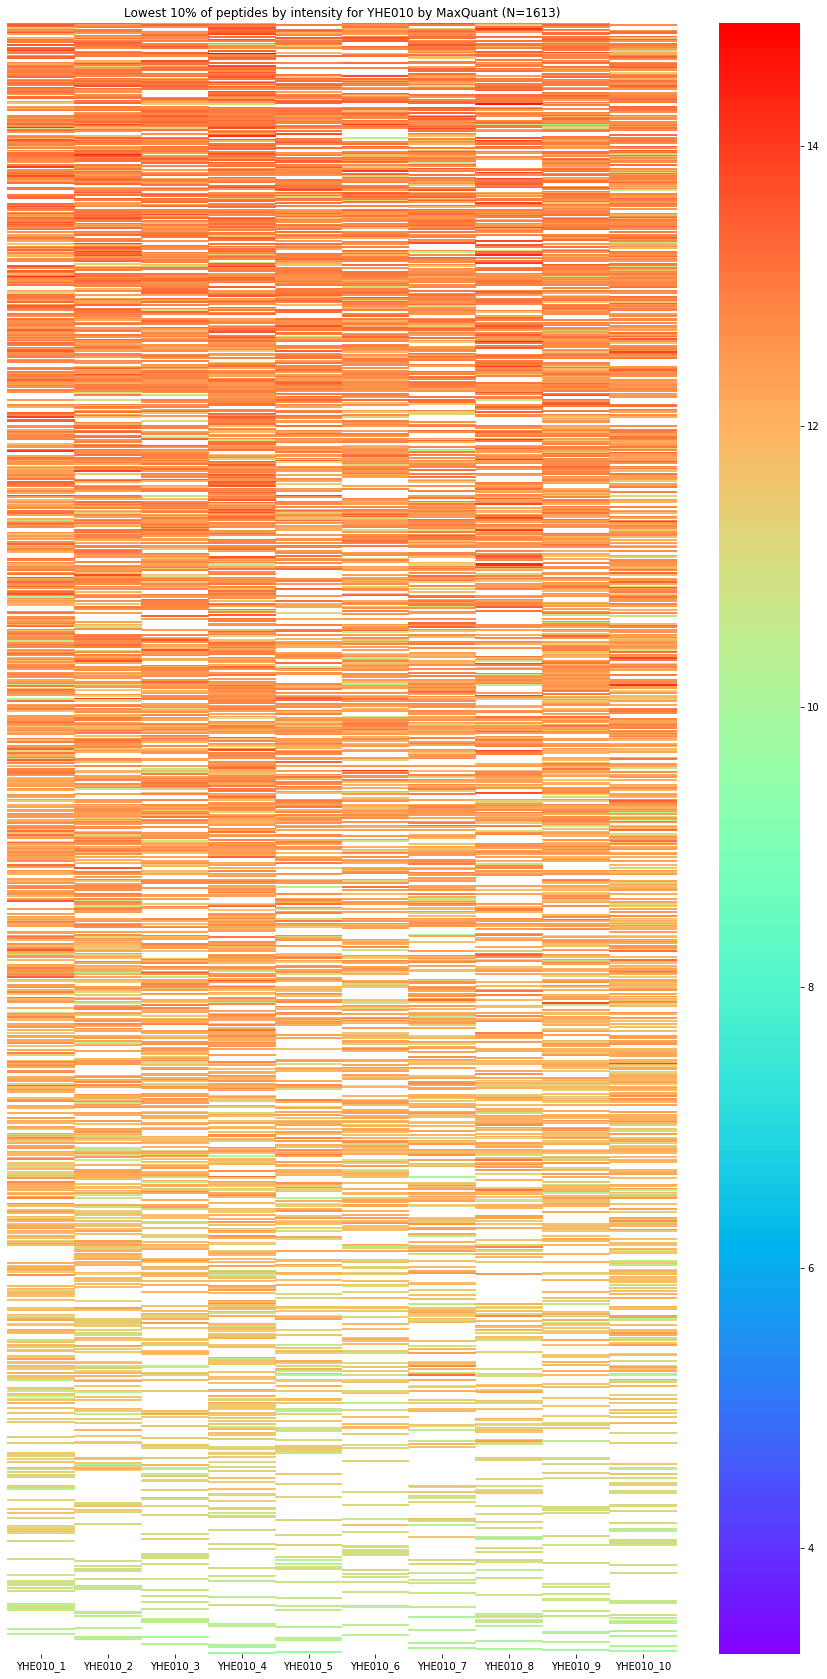

In [204]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE010 by MaxQuant (N={})'.format(int(lower_proportion*100), len(occurences_df)))

#### plot YHE114

In [205]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE114'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [206]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe114_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE114 by MaxQuant (N=1811)')

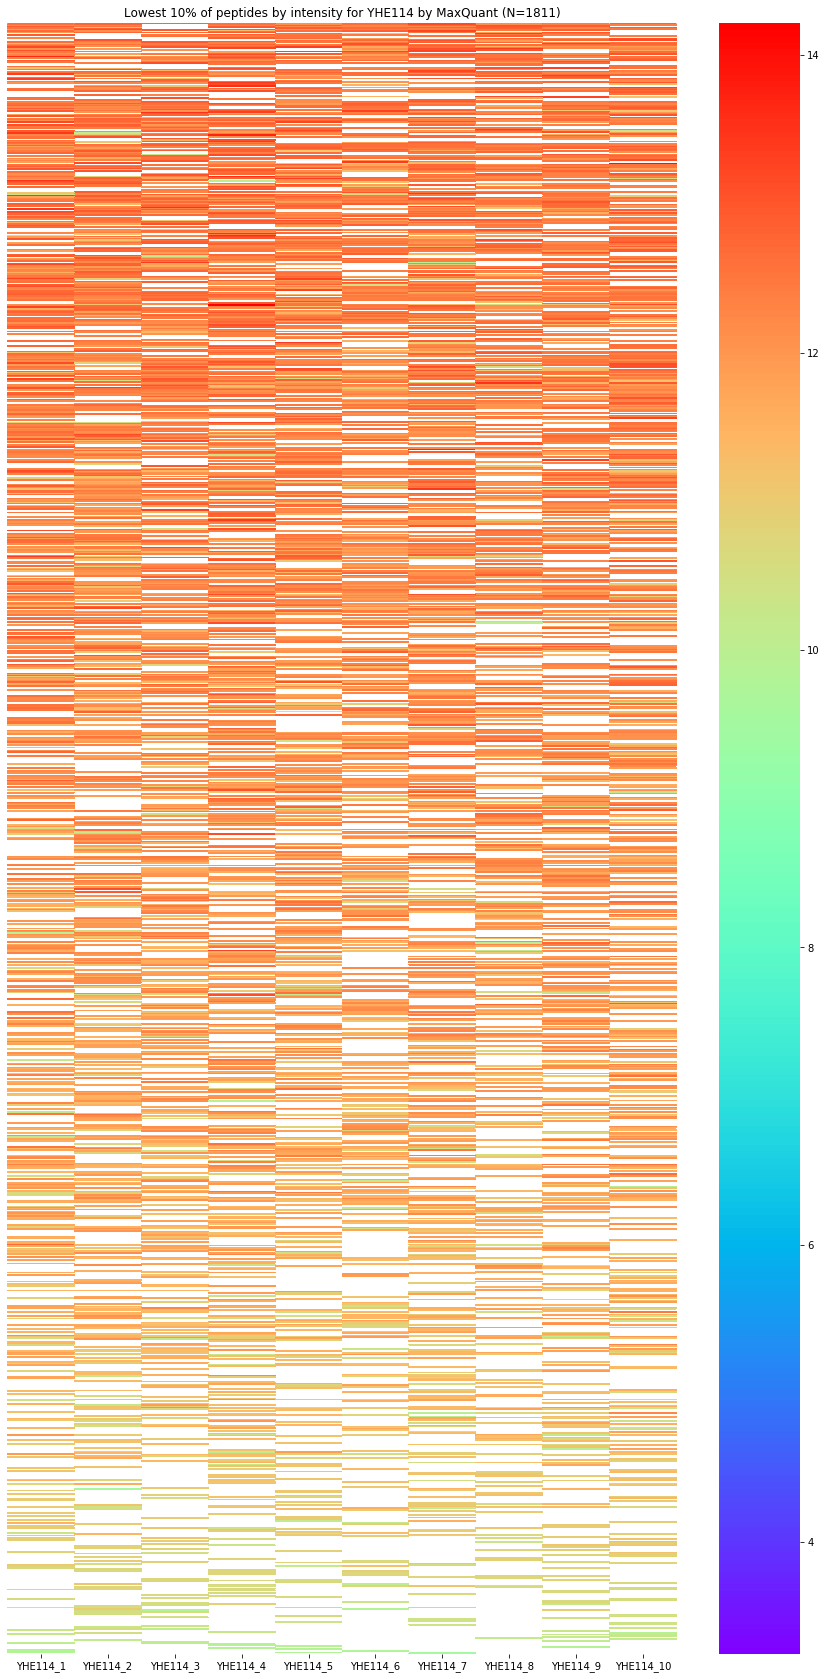

In [207]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE114 by MaxQuant (N={})'.format(int(lower_proportion*100), len(occurences_df)))

#### plot YHE211

In [208]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [209]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE211 by MaxQuant (N=1833)')

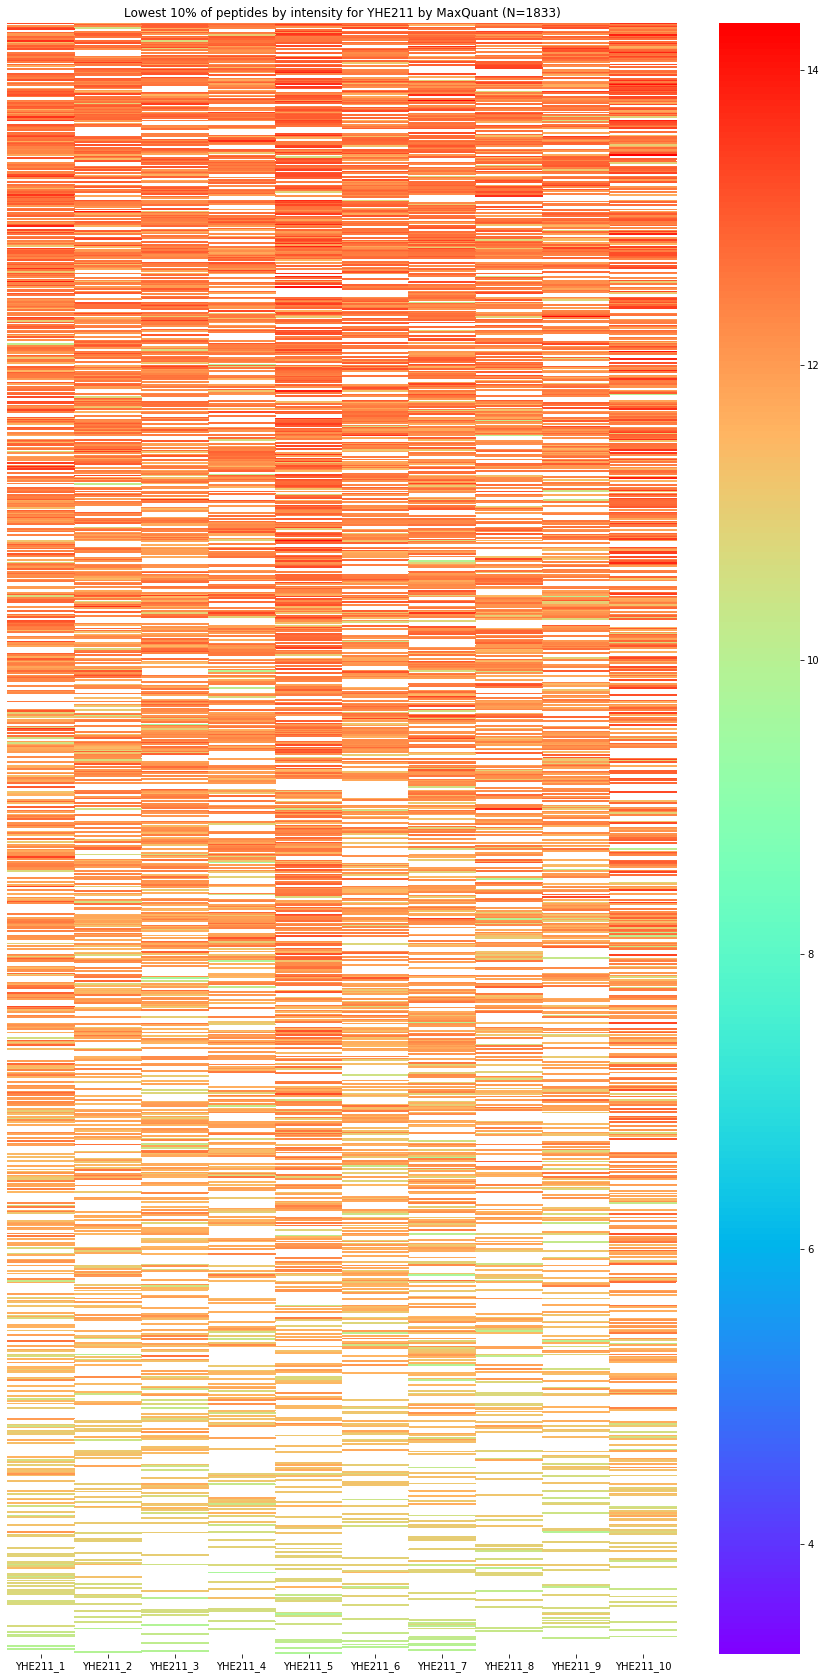

In [210]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE211 by MaxQuant (N={})'.format(int(lower_proportion*100), len(occurences_df)))

## visualise the percentage of missing values across runs